In [3]:
import numpy as np, matplotlib.pyplot as plt, glob, os, pandas as pd, copy, \
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, \
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm, json
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm
import shapely.ops, shapely.geometry as geom
from skimage.measure import label
from scipy.stats import mode
import joblib as jl
from plotnine import *
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests, fdrcorrection

import sys; sys.path.append('C:/Users/acorver/Documents/repositories/matplotlib-curly-brace/')
from curlyBrace import curlyBrace

import warnings
warnings.filterwarnings('ignore')

### Specify data files to display

In [4]:
fnameP = 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.filtered2.npy'
fnameA = 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.filtered2.npy'
fnames = [fnameP, fnameA]

In [5]:
fnames = [[x for x in glob.glob('\\\\?\\Z:\\behavior\\*\\wavelet\\{}'.format(fn)) if 'RIG' not in x] for fn in fnames]
len(fnames[0]), len(fnames[1])

(21, 21)

In [6]:
fnameP = 'Y:/wavelet/rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd/'
fnameP+= 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameP = '\\\\?\\' + fnameP.replace('/', '\\')

fnameA = 'Y:/wavelet/rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd/'
fnameA+= 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameA = '\\\\?\\' + fnameA.replace('/', '\\')

fnamesShared = [fnameP, fnameA]

fnamesWatershed = [x.replace('.npy', '.smoothed.watershed.npy') for x in fnamesShared]
fnamesWatershed = [(x if os.path.exists(x) else None) for x in fnamesWatershed]
arrWatershed = [np.load(x) for x in fnamesWatershed]

In [7]:
# Find recording information
fnamesRecordingInfo = [[os.path.join(os.path.dirname(os.path.dirname(x)), 
    'recording.json') for x in fn] for fn in fnames]

def loadJSON(x):
    if os.path.exists(x):
        with open(x, 'r') as f:
            return json.load(f)
    else:
        return None
    
recordingInfo = [[loadJSON(x) for x in fn] for fn in fnamesRecordingInfo]

# Exclude recordings that are incomplete or invalid
useRecording = [[('stages' in ri and (isinstance(ri['stages']['radii'], list) or ri['stages']['radii'] > 0) and \
    ri['web_complete'] and ri['tracking_successful']) for ri in _recordingInfo] \
        for _recordingInfo in recordingInfo]

fnames = [[x for x, b in zip(fnames[k], useRecording[k]) if b] for k in range(len(fnames))]
recordingInfo = [[x for x, b in zip(recordingInfo[k], useRecording[k]) if b] for k in range(len(fnames))]

len(fnames[0]), len(fnames[1])

(21, 21)

In [8]:
# Fill in missing stage information, if necessary
for z in tqdm(range(len(recordingInfo)), leave=False):
    for i in tqdm(range(len(recordingInfo[z])), leave=False):
        s = recordingInfo[z][i]
        # Find position/orientation
        s['fname'] = glob.glob(os.path.abspath(os.path.join(fnames[z][i], 
            '../../croprot/*dlc_position_orientation.npy')))[0]

        # Does this recording.json file specify stage ranges, or starting points?
        for st in s['stages']:
            if s['stages'][st] == []:
                s['stages'][st] = []
            elif not isinstance(s['stages'][st][0], list):
                s['stages'][st] = [s['stages'][st], ]
        
        s['stagesOrg'] = copy.deepcopy(s['stages'])
        
        # Convert to indices used in analysis
        arrIdx = np.load(s['fname'].replace('_position_orientation.npy',
                                            '_abs_filt_interp_mvmt_noborder.idx.npy'))
        for st in s['stages']:
            for k in range(len(s['stages'][st])):
                for m in range(2):
                    s['stages'][st][k][m] = np.argmin(np.abs(np.argwhere(arrIdx).T[0] - s['stages'][st][k][m]))

In [9]:
Hs = [[], []]

for z in tqdm(range(len(fnames)), leave=False):
    for i in tqdm(range(len(fnames[z])), leave=False):
        _H = {}
        for stage in recordingInfo[z][i]['stages']:
            # Load embedded data
            arr = np.load(fnames[z][i].replace('.filtered2.npy', '.clusters.npy')).copy()[:,0]
            # Determine what frame ranges belong to this stage
            idxSS = np.full(arr.shape[0], False, dtype=np.bool)
            for i0, i1 in recordingInfo[z][i]['stages'][stage]:
                idxSS[i0:i1] = True
            # Keep only embedding data in the current stage
            arr = arr[idxSS]
            arr = arr[~np.isnan(arr)]
            # Compute histogram
            _H[stage] = arr.copy().astype(int)
        Hs[z].append(_H)

In [10]:
def toNumber(x):
    try:
        return int(x)
    except:
        return -1
    
def loadLabels(fnameLabels):
    txtClusterLabels = ''
    with open(fnameLabels, 'r') as f:
        txtClusterLabels = f.read()
    clusterLabels = {}
    curLabel = ''
    for line in txtClusterLabels.split('\n'):
        if ':' in line:
            curLabel = line[:line.find(':')]
        elif len(line.strip()) > 0:
            clusterLabels[curLabel] = [toNumber(x) for x in line.split(',') if toNumber(x) >= 0]
    return clusterLabels

In [11]:
fnameClusterLabelsA = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd\\cluster_names.txt'
fnameClusterLabelsP = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\cluster_names.txt'
fnamesLabels = (fnameClusterLabelsP, fnameClusterLabelsA)

clusterLabels = (loadLabels(fnamesLabels[0]), loadLabels(fnamesLabels[1]))
clusterLabelsUnique = list(set(list(clusterLabels[0].keys()) + list(clusterLabels[1].keys())))
clusterLabelsUnique = [x for x in clusterLabelsUnique if x not in ['noisy',]]

In [11]:
# Load 

In [12]:
fnamesLimbs = [glob.glob(os.path.abspath(os.path.join(os.path.dirname(fn), 
    '../croprot/*_dlc_abs_filt_interp_mvmt_noborder.npy')))[0] for fn in fnames[0]]

In [13]:
arrLimbs = [np.load(fn) for fn in tqdm(fnamesLimbs)]

### Compute leg sweep statistics

In [14]:
fnamesClusters = [[x.replace('.filtered2.npy', '.clusters.npy') for x in y] for y in fnames]

In [15]:
arrClusters = [[np.load(x)[:,0] for x in y] for y in fnamesClusters]

In [16]:
arrClustersA = arrClusters[1]

In [17]:
rLegEvents = [np.isin(x, clusterLabels[1]['right-leg']) for x in arrClustersA]
lLegEvents = [np.isin(x, clusterLabels[1]['left-leg']) for x in arrClustersA]

In [18]:
hubs = [np.array(x['center']) for x in recordingInfo[0]]

In [19]:
# Orientation of spider: Is right side of spider closer to the hub?
LEFTJOINTS = [10, 6, 9, 13]
RIGHTJOINTS= [22, 18, 21, 25]

In [20]:
rightLegTowardsHub = []
distanceFromHub = []
for i in range(len(arrLimbs)):
    distL = np.min(np.linalg.norm(arrLimbs[i][:, LEFTJOINTS, :2] - \
        np.array(hubs[i])[np.newaxis, np.newaxis, :], axis=2), axis=1)
    
    distR = np.min(np.linalg.norm(arrLimbs[i][:, RIGHTJOINTS, :2] - \
        np.array(hubs[i])[np.newaxis, np.newaxis, :], axis=2), axis=1)
    
    dHub = np.linalg.norm(arrLimbs[i][:,0,:2] - hubs[i][np.newaxis, :], axis=1)
    
    rightLegTowardsHub.append(distR < distL)
    distanceFromHub.append(dHub)

In [21]:
def smoothMode(x, window=50):
    return pd.DataFrame(x).rolling(window=window).apply(lambda y: mode(y).mode).values[:,0]

In [22]:
rightLegTowardsHubSmooth = jl.Parallel(n_jobs=25)(jl.delayed(smoothMode)(x) for x in rightLegTowardsHub)

In [23]:
#plt.figure(figsize=(14, 4))
#plt.plot(rightLegTowardsHub[0])
#plt.plot(rightLegTowardsHubSmooth[0])

In [23]:
def getEvents(a, minFrameGap = 50):
    numEvents = 0
    lastEventI = -minFrameGap
    eventDuration = 0
    events = []
    for i in range(a.shape[0]):
        if a[i] and (i-lastEventI) >= minFrameGap and eventDuration < 12:
            eventDuration += 1
            if eventDuration == 12: # Reached min-duration threshold of 240 ms
                lastEventI = i
                numEvents += 1
                events.append( (i-6) )
        elif not a[i]:
            eventDuration = 0
    return events

In [24]:
stagesAll = []
STAGEORDER = ['protoweb', 'radii', 'spiral_aux', 'spiral_cap', 'stabilimentum']
for i in range(len(lLegEvents)):
    # Keep track of stages
    stages = np.full(len(lLegEvents[i]), -1, dtype=int)
    for st in recordingInfo[1][i]['stages']:
        if len(recordingInfo[1][i]['stages'][st]) > 0:
            if isinstance(recordingInfo[1][i]['stages'][st][0], list) or \
                    isinstance(recordingInfo[1][i]['stages'][st][0], tuple):
                for ki, k in enumerate(recordingInfo[1][i]['stages'][st]):
                    stages[k[0]:k[1]] = STAGEORDER.index(st) + 0 * ki
            else:
                if len(recordingInfo[1][i]['stages'][st]) == 2:
                    stages[recordingInfo[1][i]['stages'][st][0]:recordingInfo[1][i]['stages'][st][1]] = STAGEORDER.index(st)
    stagesAll.append(stages)

In [25]:
d = []
for recid in range(len(lLegEvents)):
    iscanonical = np.diff(stagesAll[recid][stagesAll[recid] >= 0]).min() >= 0
    for leg in ['left', 'right']:
        for event in getEvents((lLegEvents if leg=='left' else rLegEvents)[recid]):
            _stage = STAGEORDER[stagesAll[recid][event]] if stagesAll[recid][event] >= 0 else ''
            d.append((recid, leg, event, 
                      rightLegTowardsHubSmooth[recid][event],
                      distanceFromHub[recid][event],
                      _stage, iscanonical))
d = pd.DataFrame(d, columns=['recid', 'leg', 'event', 'rightLegTowardsHub', 'distanceFromHub', 'stage', 'canonical'])

### Misc. (a)canonical stats

In [26]:
dTmp = d.copy() 
dTmp = dTmp.loc[:,['recid', 'leg', 'rightLegTowardsHub', 'event', 'stage', 'canonical']].groupby(
    ['recid', 'leg', 'rightLegTowardsHub', 'stage', 'canonical']).count().reset_index()
dTmp.loc[:,'direction'] = [['CCW', 'CW'][int(x)] for x in dTmp.rightLegTowardsHub]
dTmp = dTmp[dTmp.stage != '']
dTmp.head()

,recid,leg,rightLegTowardsHub,stage,canonical,event,direction
0,0,left,0.0,protoweb,True,175,CCW
1,0,left,0.0,radii,True,109,CCW
2,0,left,0.0,spiral_aux,True,50,CCW
3,0,left,0.0,spiral_cap,True,390,CCW
4,0,left,0.0,stabilimentum,True,9,CCW


In [47]:
import regex as re

# Determine spider ID labels
def getSpiderID(x):
    k = ['a', 'b', 'd', 'e', 'mvs~'].index(re.search('[0-9]+-[0-9]+-[0-9]+-([a-z~]*)', x).group(1))
    return ['A', 'B', 'C', 'D', 'E'][k]

In [ ]:
canonicalBySpider = list(zip([getSpiderID(x) for x in fnames[0]], 
                             [dTmp.canonical[dTmp.recid==x].values[0] for x in range(21)]))
canonicalBySpider = [[y[1] for y in canonicalBySpider if y[0]==spiderID] for spiderID in ['A', 'B', 'C', 'D', 'E']]
plt.hist([np.mean(x).round(2) for x in canonicalBySpider])

In [75]:
canonicalBySpider

[[False, False, False, True, False, False, False],
 [True, True, False, True, False, False, False, True],
 [True],
 [True, True, True, True],
 [False]]

In [74]:
'Atypical Webs: ' + ', '.join(['{}/{}'.format(len(y)-np.sum(y), len(y)) for y in canonicalBySpider])

'Atypical Webs: 6/7, 4/8, 0/1, 0/4, 1/1'

In [68]:
from scipy.stats import kruskal
kruskal(*[[int(y) * 2 - 1 for y in x] for x in canonicalBySpider])

KruskalResult(statistic=9.090909090909102, pvalue=0.05886692128914312)

## Plot 1

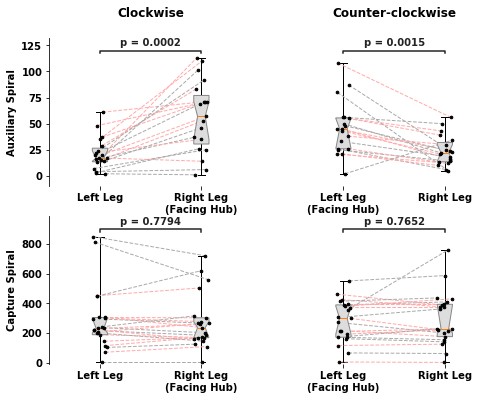

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

pvals = [[None, None], [None, None]]
for istage, stage in enumerate(['spiral_aux', 'spiral_cap']):
    for iclockwise, clockwise in enumerate(['CW', 'CCW']):
        a1 = dTmp.event[(dTmp.stage==stage)&(dTmp.direction==clockwise)&(dTmp.leg=='left')]
        a2 = dTmp.event[(dTmp.stage==stage)&(dTmp.direction==clockwise)&(dTmp.leg=='right')]
        pvals[istage][iclockwise] = wilcoxon(x=a1, y=a2).pvalue
#pvals = multipletests(np.array(pvals).reshape((-1)), method='bonferroni')[1].reshape((2, 2))

for istage, stage in enumerate(['spiral_aux', 'spiral_cap']):
    for iclockwise, clockwise in enumerate(['CW', 'CCW']):
        xticks = [1, 2] #[0, 0.75]
        yvals = [dTmp.event[(dTmp.stage==stage)&(dTmp.direction==clockwise)&
                            (dTmp.leg==lg)].values for lg in ['left', 'right']]
        iscan = [dTmp.canonical[(dTmp.stage==stage)&(dTmp.direction==clockwise)&
                            (dTmp.leg==lg)].values for lg in ['left', 'right']]

        bplot = ax[istage][iclockwise].boxplot(yvals, patch_artist=True, bootstrap=10000,
            notch=True, vert=True, boxprops={'facecolor': '#dddddd', 'edgecolor': '#888888'}, whis=(0,100))
        
        ax[istage][iclockwise].set_xticks(xticks)
        if clockwise == 'CW':
            ax[istage][iclockwise].set_xticklabels(['Left Leg', 'Right Leg\n(Facing Hub)'])
        else:
            ax[istage][iclockwise].set_xticklabels(['Left Leg\n(Facing Hub)', 'Right Leg'])

        if iclockwise != 0:
            ax[istage][iclockwise].spines["left"].set_visible(iclockwise == 0)
            ax[istage][iclockwise].get_yaxis().set_visible(False)
        ax[istage][iclockwise].spines["top"].set_visible(False)
        ax[istage][iclockwise].spines["right"].set_visible(False)
        ax[istage][iclockwise].spines["bottom"].set_visible(False)

        assert(yvals[0].size == yvals[1].size)
        sc = np.zeros((yvals[0].shape[0], 4))
        for k in range(2):
            sc[:,k*2+0] = xticks[k] 
            sc[:,k*2+0]+= (np.random.random(yvals[k].size) - 0.5) * 0.15
            sc[:,k*2+1] = yvals[k]

        for k in range(sc.shape[0]):
            ax[istage][iclockwise].plot([sc[k,0], sc[k,2]], 
                                  [sc[k,1], sc[k,3]], 
                color='#aaaaaa' if iscan[0][k] else '#ffaaaa', linestyle='--', linewidth=1)

        ax[istage][iclockwise].scatter(sc[:,0], sc[:,1], s=7, color='black', zorder=10)
        ax[istage][iclockwise].scatter(sc[:,2], sc[:,3], s=7, color='black', zorder=10)
        
        ttl = ''
        if istage == 0:
            ttl += ['Clockwise', 'Counter-clockwise'][iclockwise] + '\n'
        
        ymax = 120 if istage==0 else 900
        ax[istage][iclockwise].set_ylim([-10, ymax * 1.1])
        
        ax[istage][iclockwise].set_title(ttl)
        
        ax[istage][iclockwise].plot([xticks[0], xticks[0], xticks[1], xticks[1]], 
                                    [0.98*ymax, ymax, ymax, 0.98*ymax], lw=1.5, c='#222222')
        ax[istage][iclockwise].text((xticks[0]+xticks[1])*.5, ymax*1.02, 
            'p = {:.4f}'.format(pvals[istage][iclockwise]), ha='center', va='bottom', color='#222222')
        
        if iclockwise == 0:
            ax[istage][iclockwise].set_ylabel(['Auxiliary Spiral', 'Capture Spiral'][istage])

#fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_Legsweep_Direction_Boxplot.pdf')

## Plot 2

In [31]:
dTmp = d[(d.stage.isin(['spiral_aux', 'spiral_cap']))&(~pd.isnull(d.rightLegTowardsHub))].copy()
dTmp.loc[:,'direction'] = [['CCW', 'CW'][int(x)] for x in dTmp.rightLegTowardsHub]

In [32]:
#dTmp.loc[:,'distanceFromHubMax'] = dTmp.groupby('recid').transform('max').distanceFromHub
#dTmp.loc[:,'distanceFromHubRel'] = dTmp.distanceFromHub / dTmp.distanceFromHubMax
#dTmp.distanceFromHub = dTmp.distanceFromHubRel * 600

In [33]:
# Source: http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html
def bootstrap(data, n=1000, func=np.nanmean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

In [34]:
# Source: https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-a-list-of-lists
flatten = lambda t: [item for sublist in t for item in sublist]

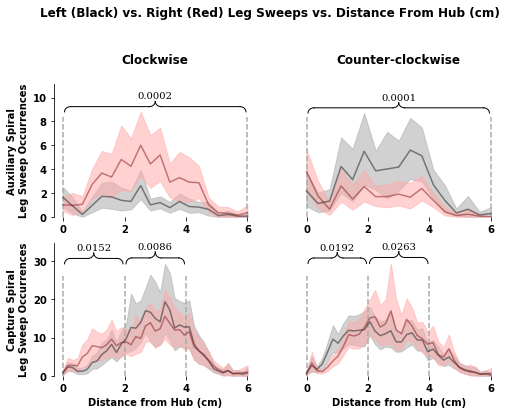

In [41]:
FIG_ID, density, normalize = 4, False, False
PIXEL_TO_CM = 0.01
#fdr_method = 'fdr_bh'

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
fig.subplots_adjust(top=0.8)

ipval = 0
pvals = []
def _spans(stage, clockwise):
    return [[0, 6],] if stage == 'spiral_aux' else [[0, 2], [2, 4]]
for istage, stage in enumerate(['spiral_aux', 'spiral_cap']):
    for iclockwise, clockwise in enumerate(['CW', 'CCW']):
        spans = _spans(stage, clockwise)
        _pvals = []
        for ispan, span in enumerate(spans):
            tmp = pd.pivot_table(dTmp.loc[(dTmp.stage==stage)&(dTmp.direction==clockwise)&(
                dTmp.distanceFromHub.between(span[0] / PIXEL_TO_CM, span[1] / PIXEL_TO_CM)), 
                ['recid', 'leg', 'event']].groupby(['leg', 'recid']).count().reset_index(), 
                values='event', index=['recid'], columns='leg')
            tmp = tmp.fillna(0.0)
            pv = wilcoxon(tmp.left - tmp.right).pvalue
            _pvals.append(pv)
        _pvals = multipletests(_pvals, method='holm')[1]
        pvals += _pvals.tolist()
        
#pvals = multipletests(pvals, method='fdr_by')[1]
            
for istage, stage in enumerate(['spiral_aux', 'spiral_cap']):
    for iclockwise, clockwise in enumerate(['CW', 'CCW']):
        nbins = np.max([np.histogram(dTmp.distanceFromHub[(dTmp.stage==stage)&
            (dTmp.direction==clockwise)&(dTmp.leg==leg)], bins='fd', 
            range=(0,600), density=density)[0].size for leg in ['left', 'right']])

        z = np.array([[np.histogram(dTmp.distanceFromHub[(dTmp.stage==stage)&
            (dTmp.direction==clockwise)&(dTmp.leg==leg)&(dTmp.recid==recid)], bins=nbins, 
            range=(0,600), density=density)[0]/(
                1 if not normalize else np.sum((dTmp.stage==stage)&(dTmp.direction==clockwise)&(dTmp.recid==recid))
            ) for recid in range(21)] for leg in ['left', 'right']])

        ciAll = [np.array([bootstrap(z[k][:,w], 10000, np.nanmean)(0.95) for w in \
            range(z[k].shape[1])]) for k in range(2)]

        for k in range(2):
            ci = ciAll[k]
            zm = np.nanmean(z[k], axis=0)
            #zsem = np.nanstd(z[k], axis=0) / np.sqrt(z[k].shape[0])
            #ci = (zm - zsem, zm + zsem)
            xs = np.linspace(0, 600 * PIXEL_TO_CM, zm.size)

            ax[istage][iclockwise].fill_between(xs, ci[:, 0], ci[:, 1], 
                color='#aaaaaa88' if k == 0 else '#ffaaaa88')
            ax[istage][iclockwise].plot(xs, zm, 
                color='#22222288' if k == 0 else '#88222288', zorder=10)

        if iclockwise != 0:
            ax[istage][iclockwise].spines["left"].set_visible(iclockwise == 0)
            ax[istage][iclockwise].get_yaxis().set_visible(False)
        ax[istage][iclockwise].spines["top"].set_visible(False)
        ax[istage][iclockwise].spines["right"].set_visible(False)
        ax[istage][iclockwise].spines["bottom"].set_visible(False)
        
        ymax = np.nanmax(ciAll)
        spans = _spans(stage, clockwise)
        braceSc = 0.033 if stage == 'spiral_aux' else 0.1
        for ispan, span in enumerate(spans):
            pv = pvals[ipval]
            ipval += 1
            curlyBrace(fig, ax[istage][iclockwise], 
               [span[0]+0.05, ymax], [span[1]-0.05, ymax], braceSc, bool_auto=True, 
               str_text='{:.4f}'.format(pv), color='black', lw=1, 
               int_line_num=1, fontdict={
                   'family': 'serif', 'color':  'k', 'size': 10})
            
        for xi in list(set(flatten(spans))):
            ax[istage][iclockwise].axvline(xi, color='#aaaaaa', ymin=0, ymax=0.75, linestyle='--')
        
        ttl = ''
        if istage == 0:
            ttl += ['Clockwise', 'Counter-clockwise'][iclockwise] + '\n'
        elif istage == 1:
            ax[istage][iclockwise].set_xlabel('Distance from Hub (cm)')
        ax[istage][iclockwise].set_title(ttl)
        
        ax[istage][iclockwise].set_ylim(0, ymax * 1.15 + 1)

        if iclockwise == 0:
            ax[istage][iclockwise].set_ylabel([
                'Auxiliary Spiral\nLeg Sweep Occurrences', 
                'Capture Spiral\nLeg Sweep Occurrences'][istage])
        
fig.suptitle('Left (Black) vs. Right (Red) Leg Sweeps vs. Distance From Hub (cm)\n{}'.format(
    'First Normalized by Total # Leg Sweeps Per Recordings' if normalize else (
    'Left/Right Leg Histograms for Each Recording First Normalized To Density (Sum=1)' if density else ''
    )
))
fig.show()
fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_Legsweep_DirectionBias_vs_DistFromHub_{}_{}_0.05_test.pdf'.format(FIG_ID, fdr_method))